<a href="https://colab.research.google.com/github/ShivajiMallela/Deep-learning-with-Tensorflow/blob/main/6_Transfer_learning_in_tensorflow_part_3%3A%20Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

In the previous two notebooks, we've explored the power of transfer learning:

- [Transfer Learning Part 1: Feature Extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb)
- [Transfer Learning Part 2: Fine-Tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb)

Now that our smaller modeling experiments have shown promising results, it's time to scale up with more data.

This approach is a common practice in machine learning and deep learning: start by getting a model to work on a small dataset, then scale it up to a larger dataset.

It's time to get closer to our Food Vision project coming to life. In this notebook we're going to scale up from using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

Our goal is to **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data**.

## What We're Going to Cover

In this notebook, we will go through the following steps with TensorFlow:

- Downloading and preparing 10% of the Food101 dataset (10% of the training data)
- Training a feature extraction transfer learning model on this 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loading our trained model
- Evaluating the performance of our Food Vision model trained on 10% of the training data
  - Identifying our model's most incorrect predictions
- Making predictions with our Food Vision model on custom images of food


In [71]:
# Are we using a GPU?
!nvidia-smi

Sat Jul 13 01:30:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              32W /  70W |   2173MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

We've created a series of helper functions throughout the previous notebooks. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [72]:
# Getting helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-13 01:30:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-13 01:30:25 (105 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [73]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, unzip_data

## 101 Food Classes: Working with Less Data

So far, we've confirmed that the transfer learning models we've been using work well with the 10 Food Classes dataset. Now, let's step it up and see how they perform with the full 101 Food Classes.

The original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset contains 1,000 images per class (750 for training and 250 for testing), totaling 101,000 images.

Instead of starting with this large dataset, we'll continue our experimental approach by testing our previously successful models on 10% of the training data.

This means for each of the 101 food classes, we'll be building a model using 75 training images and evaluating it on 250 test images.


## Downloading and preprocessing the data

Just as before we'll download a subset of the Food101 dataset which has been extracted from the original dataset (to see the preprocessing of the data check out the [Food Vision preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) created by instructor of this course).

We download the data as a zip file so we'll use our `unzip_data()` function to unzip it.

In [74]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data('101_food_classes_10_percent.zip')

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-07-13 01:30:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   122MB/s    in 17s     

2024-07-13 01:30:43 (89.2 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [75]:
#How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 4 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/falafel'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caesar_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/dumplings'.
There are 0 directories and 75 images in '101_foo

In [76]:
# setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a Big Model with Transfer Learning on 10% of 101 Food Classes

Our food image data has been successfully imported into TensorFlow, so now it's time to model it.

To keep our experiments efficient, we'll start with feature extraction transfer learning using a pre-trained model for a few epochs, followed by fine-tuning for a few more epochs.

Our goal is to see if we can surpass the baseline accuracy from the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% accuracy on 101 classes) using 10% of the training data and the following setup:
- A [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save progress during training, allowing further experimentation without starting from scratch each time.
- Data augmentation integrated into the model.
- A headless (no top layers) [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) architecture from `tf.keras.applications` as the base model.
- A `Dense` layer with 101 neurons (matching the number of food classes) and softmax activation as the output layer.
- Categorical cross-entropy as the loss function since we have more than two classes.
- The Adam optimizer with default settings.
- Training for 5 epochs on the training data while evaluating on 15% of the test data.

Although this setup might seem complex, these elements have all been covered in the [Transfer Learning in TensorFlow Part 2: Fine-tuning notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb).

Let's begin by creating the `ModelCheckpoint` callback.

Since we want our model to perform well on unseen data, we'll set it to monitor the validation accuracy metric and save the model weights that achieve the best performance.


In [77]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True)

Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.

In [78]:
# import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name = 'data_augmentation')

We'll be able to insert the `data_augmentation` Sequential model as a layer in our Functional API model. This ensures that if we continue training our model later, the data augmentation is already integrated.

Now, let's create a feature extraction transfer learning model using the [`tf.keras.applications.efficientnet.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) as our base model.

We'll import the base model with the parameter `include_top=False`, which allows us to add our own output layers. Specifically, we'll use a `GlobalAveragePooling2D()` layer to condense the outputs of the base model into a shape usable by the output layer, followed by a `Dense` layer.


In [79]:
# Setup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False
# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

24274472/24274472 [==============================] - 0s 0us/step


In [80]:
# Get summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

Our Functional model has 5 layers but each of those layers have varying amounts of layers within them.

Notice the number of trainable and non-trainable parameters. It seems the only trainable parameters are within the `output_layer` which is exactly what we're after with this first run of feature extraction; keep all the learned patterns in the base model (`EfficientNetb0`) frozen whilst allowing the model to tune its outputs to our custom data.

Time to compile and fit.

In [81]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 200s 805ms/step - loss: 3.4950 - accuracy: 0.2451 - val_loss: 2.6557 - val_accuracy: 0.4123
Epoch 2/5
237/237 [==============================] - 134s 564ms/step - loss: 2.3870 - accuracy: 0.4602 - val_loss: 2.2475 - val_accuracy: 0.4571
Epoch 3/5
237/237 [==============================] - 100s 423ms/step - loss: 2.0175 - accuracy: 0.5229 - val_loss: 2.0147 - val_accuracy: 0.4931
Epoch 4/5
237/237 [==============================] - 87s 365ms/step - loss: 1.7951 - accuracy: 0.5636 - val_loss: 1.9501 - val_accuracy: 0.5000
Epoch 5/5
237/237 [==============================] - 84s 353ms/step - loss: 1.6623 - accuracy: 0.5934 - val_loss: 1.8807 - val_accuracy: 0.5119


In [82]:
# Evaluate the model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 57s 73ms/step - loss: 1.6234 - accuracy: 0.5672


[1.6233644485473633, 0.5672475099563599]

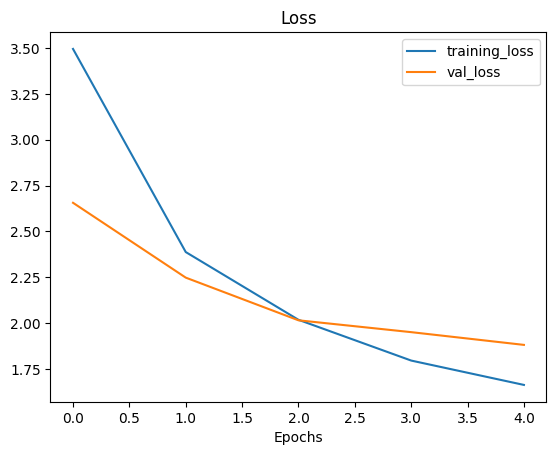

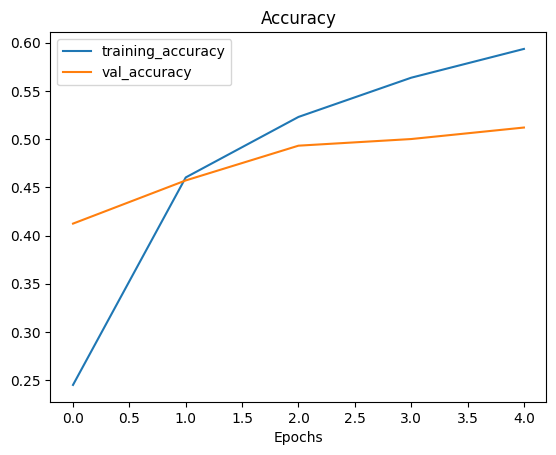

In [83]:
# plot loss curves
plot_loss_curves(history_all_classes_10_percent)

## Fine tuning

Our feature extraction transfer learning model is performing well. Let's try fine-tuning a few layers in the base model to see if we can achieve further improvements.

The good news is that, thanks to the `ModelCheckpoint` callback, we have the saved weights of our well-performing model. If fine-tuning doesn't yield any benefits, we can revert back.

To fine-tune the base model, we'll first set its `trainable` attribute to `True`, unfreezing all the layers.

Since we have a relatively small training dataset, we'll refreeze all layers except for the last 5, making only those layers trainable.


In [84]:
# unfreeze all the layers in the base model
base_model.trainable = True

# refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [85]:
# Recompile it with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [86]:
# what layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_average_pooling True
output_layer True


In [87]:
# what layers in the base model are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [88]:
# fine tune for 5 more epochs
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1],
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15*len(test_data)))

Epoch 5/10
237/237 [==============================] - 91s 342ms/step - loss: 1.4577 - accuracy: 0.6305 - val_loss: 1.7983 - val_accuracy: 0.5220
Epoch 6/10
237/237 [==============================] - 71s 296ms/step - loss: 1.3468 - accuracy: 0.6573 - val_loss: 1.7578 - val_accuracy: 0.5336
Epoch 7/10
237/237 [==============================] - 64s 269ms/step - loss: 1.2893 - accuracy: 0.6639 - val_loss: 1.7598 - val_accuracy: 0.5344
Epoch 8/10
237/237 [==============================] - 58s 242ms/step - loss: 1.2354 - accuracy: 0.6750 - val_loss: 1.7671 - val_accuracy: 0.5294
Epoch 9/10
237/237 [==============================] - 55s 230ms/step - loss: 1.2061 - accuracy: 0.6842 - val_loss: 1.7481 - val_accuracy: 0.5376
Epoch 10/10
237/237 [==============================] - 57s 241ms/step - loss: 1.1776 - accuracy: 0.6875 - val_loss: 1.7534 - val_accuracy: 0.5365


In [89]:
# Evaluate on whole test data
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 55s 69ms/step - loss: 1.4782 - accuracy: 0.6021


[1.4781585931777954, 0.6020594239234924]

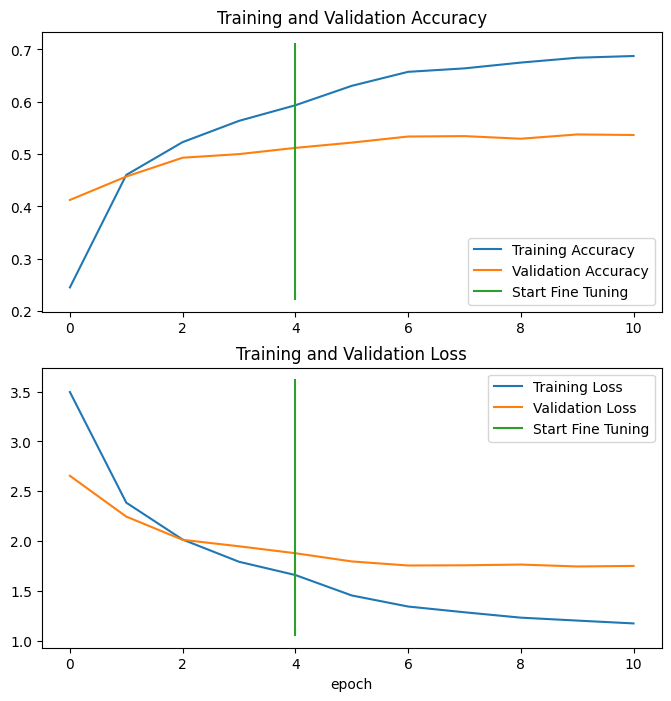

In [90]:
# compare historys of previous model(feature_extraction) and fine tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly, but the validation metrics did not show much improvement. This indicates that our model is starting to overfit.

This is a common occurrence when fine-tuning, especially if the data used to pre-train the model is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0`, was trained on [ImageNet](http://www.image-net.org/index), which includes many real-life pictures of food similar to our food dataset.

When feature extraction already works well, the improvements from fine-tuning may not be substantial if your dataset is quite similar to the data your base model was pre-trained on.


## Saving our trained model

To prevent having to retrain our model from scratch, let's save it to file using the [`save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method.

In [91]:
# # Save model to drive so it can be used later
# model.save("drive/MyDrive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

## Evaluating the Performance of the Model Across All Classes

We have a trained and saved model that, according to our evaluation metrics, is performing fairly well.

However, metrics alone don't tell the full story. Let's dive deeper into our model's performance by generating some visualizations.

We'll start by loading the saved model and using it to make predictions on the test dataset.

> 🔑 **Note:** Evaluating a machine learning model is just as important as training one. Metrics can be misleading. Always visualize your model's performance on unseen data to ensure you aren't being deceived by good-looking training numbers.


In [92]:
import tensorflow as tf

# Download pre-trained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
save_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(save_model_path)

--2024-07-13 01:51:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.2’

06_101_food_class_1 100%[===================>]  44.59M   234MB/s    in 0.2s    

2024-07-13 01:51:47 (234 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.2’ saved [46760742/46760742]



In [93]:
model = tf.keras.models.load_model(save_model_path.split(".")[0]) # we can also pass the path directly without including .zip in the filename

In [94]:
# check to see if model loaded is a trained model or not
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 57s 70ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027204275131226, 0.6077623963356018)

### Making Predictions with Our Trained Model

To evaluate our trained model, we will make predictions with it and compare those predictions to the test dataset.

Since the model has never seen the test dataset, this will give us an indication of how well it will perform in the real world on data similar to what it was trained on.

To make predictions, we will use the `predict()` method on the test data.

Since our data is multi-class, this will return a probability tensor for each sample. Essentially, for each image, the trained model will compare it against all patterns it learned during training and return a probability distribution across all 101 classes, indicating how likely the image belongs to each class.


In [95]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

790/790 [==============================] - 65s 80ms/step


In [96]:
# How many predictions are there?
len(pred_probs)

25250

In [97]:
# What's the shape of our predictions
pred_probs.shape

(25250, 101)

In [98]:
# How do they look?
pred_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [99]:
# Get one prediction probability per class
print(f"Number of predictions probabilites for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of predictions probabilites for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [100]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

Now that we have the predicted class index for each sample in our test dataset, we can compare these predictions to the actual test dataset labels to further evaluate our model.

To obtain the test dataset labels, we can unravel our `test_data` object, which is a `tf.data.Dataset`, using the [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch) method.

This process allows us to access both the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll use the `argmax()` method to retrieve the index of the label.

> 🔑 **Note:** We use `shuffle=False` when creating the test data object to prevent shuffling every time we load the test dataset (such as when making predictions). If the dataset were shuffled each time, comparing predictions to labels would be problematic due to potential mismatched orders.


In [101]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Nice! Since `test_data` isn't shuffled, the `y_labels` array comes back in the same order as the `pred_classes` array.

The final check is to see how many labels we've got.

In [102]:
# How many labels are there?
len(y_labels)

25250

### Evaluating Our Model's Predictions

A straightforward way to evaluate our model is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function. This function compares the true labels to the predicted labels and returns an accuracy score.

If we've correctly organized our `y_labels` (true labels) and `pred_classes` (predicted classes) arrays, this should yield a similar accuracy value (or very close) to the `evaluate()` method we used earlier.



In [103]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [104]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: 2.0097978059574473e-08



How about we get a little bit more visual with a confusion matrix?

To do so, we'll use our `make_confusion_matrix` function we created in a previous notebook.

In [105]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
from helper_functions import make_confusion_matrix

In [106]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [107]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [108]:
# plot confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      norm=False,
                      savefig=True)

The confusion matrix may appear overwhelming at first glance, but upon closer inspection, it provides valuable insights into which classes the model is "confused" on.

The good news is that the majority of predictions fall along the diagonal from the top-left to bottom-right, indicating correct predictions.

It seems that the model struggles most with classes that appear visually similar, such as predicting `filet_mignon` for instances of `pork_chop` and `chocolate_cake` for instances of `tiramisu`.

Since we're dealing with a classification problem, we can further evaluate our model's predictions using Scikit-Learn's [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function.


In [109]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The `classification_report()` function outputs precision, recall, and F1-score for each class.

To recap:
* **Precision** - Proportion of true positives over the total number of samples. Higher precision indicates fewer false positives (model predicts 1 when it should have predicted 0).
* **Recall** - Proportion of true positives over the total number of true positives and false negatives. Higher recall indicates fewer false negatives (model predicts 0 when it should have predicted 1).
* **F1-score** - Harmonic mean of precision and recall. A score of 1 is best, while 0 is worst.

While the output is informative, interpreting results for many classes can be challenging. Let's simplify it with a visualization.

First, we'll obtain the output of `classification_report()` as a dictionary by setting `output_dict=True`.


In [110]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9


Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called `class_f1_scores` and then loop through each item in `classification_report_dict`, appending the class name and f1-score as the key, value pairs in `class_f1_scores`.

In [111]:
# create empty dictionary
class_f1_scores={}
for k, v in classification_report_dict.items():
  if k=='accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

It seems like our dictionary is ordered by the class names. However, I think if we're trying to visualize different scores, it might look nicer if they were in some kind of order.

How about we turn our `class_f1_scores` dictionary into a pandas DataFrame and sort it in ascending fashion?

In [112]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-score":list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

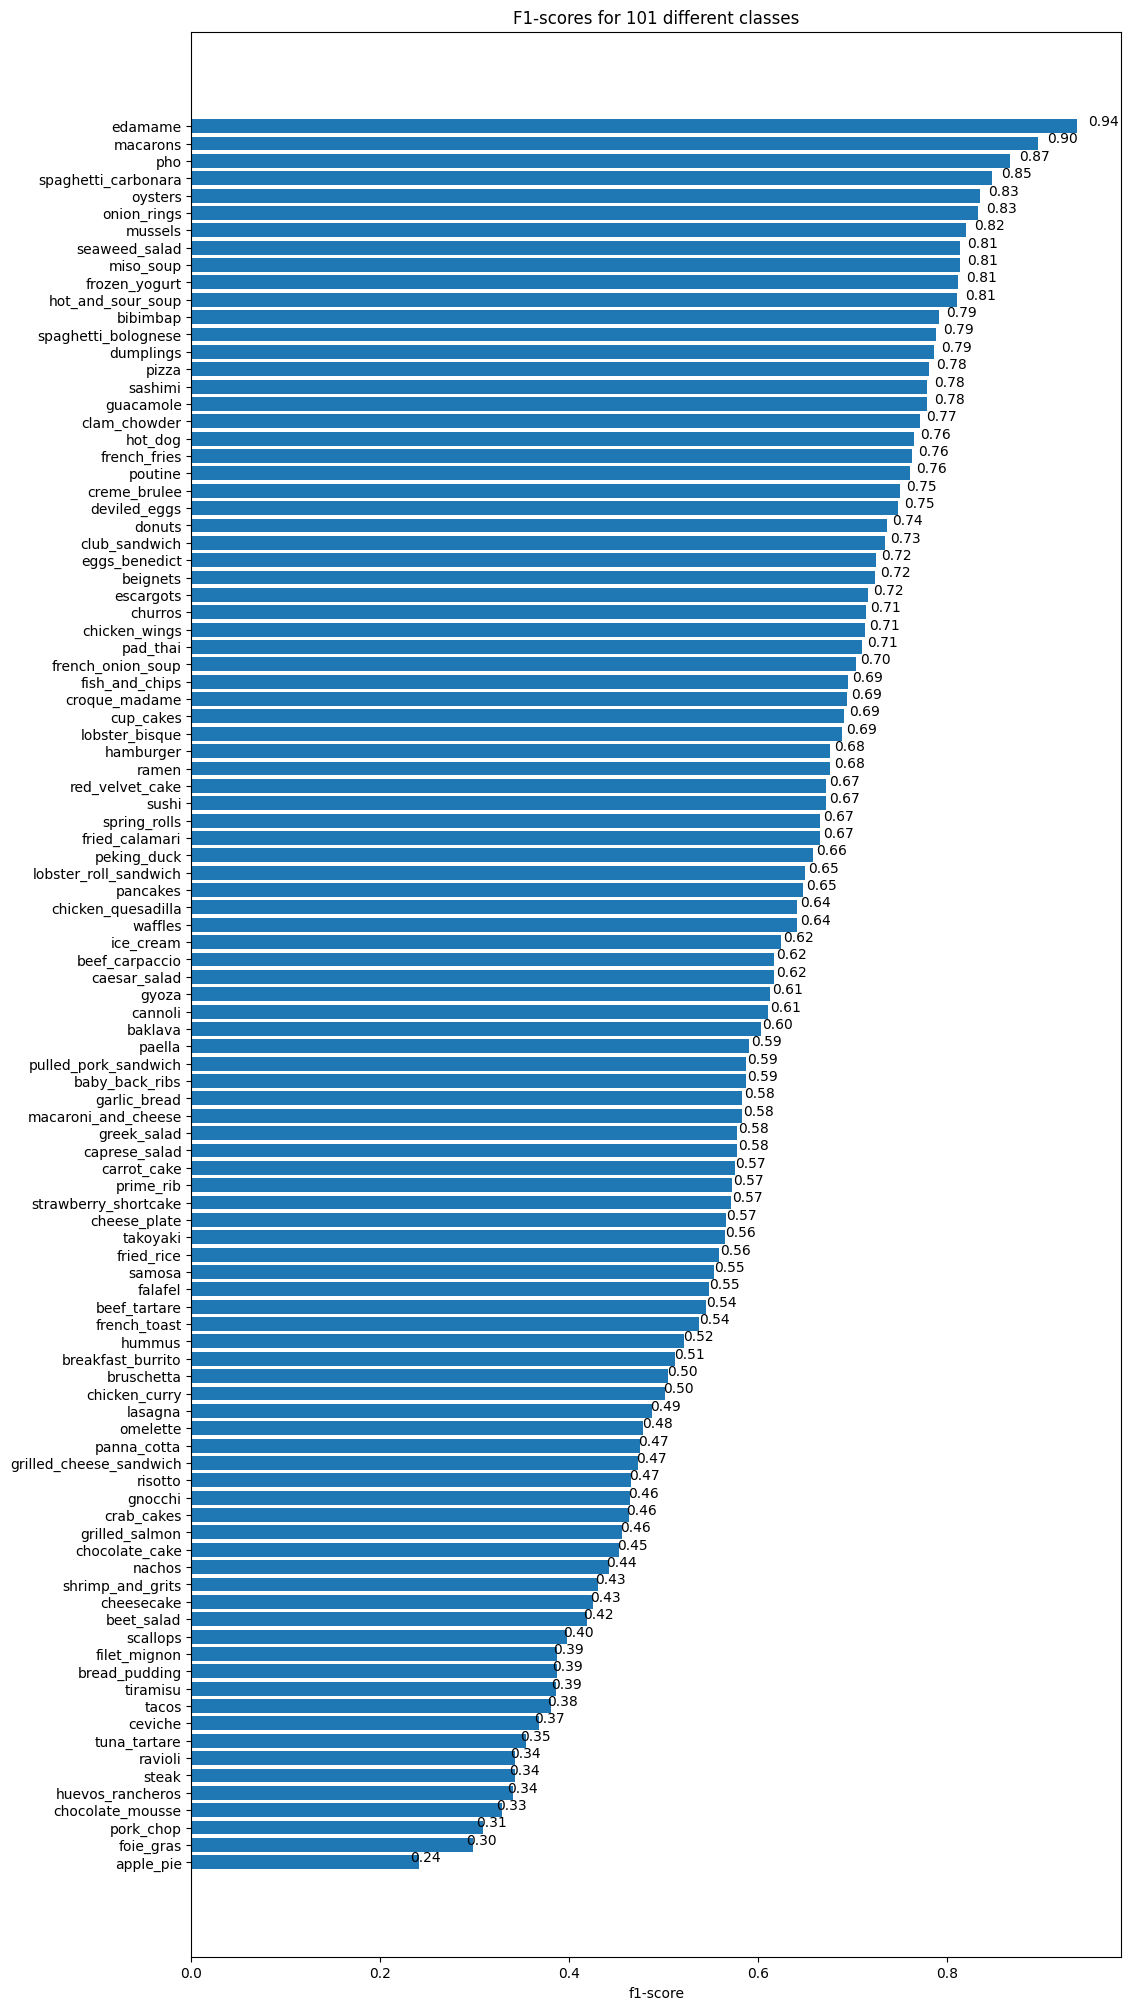

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel('f1-score')
ax.set_title("F1-scores for 101 different classes")
ax.invert_yaxis();

def autolabel(rects):
  """
    Attach a text label above each bar displaying its height (it's value).
  """

  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Visualizing Predictions on Test Images

Now it's time for the real test: visualizing predictions on actual images. While metrics are informative, visualizing predictions on real images gives a more intuitive understanding of how well your model is performing.

Currently, our model cannot predict on just any image; the image needs to be loaded into a tensor first. To enable prediction on any given image, we'll create a function to load an image into a tensor.

Specifically, this function will:

* Read the target image file path using [`tf.io.read_file()`](https://www.tensorflow.org/api_docs/python/tf/io/read_file).
* Convert the image into a `Tensor` using [`tf.io.decode_image()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_image).
* Resize the image to match the dimensions used for training our model (224 x 224) using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize).
* Scale the image to ensure all pixel values are between 0 and 1 if necessary.


In [114]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  #Rread in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img, channels=3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all the values between 0 and 1)
    return img/255.
  else:
    return img

Image loading and preprocessing function ready.

Now let's write some code to:

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

1/1 [==============================] - 0s 39ms/step


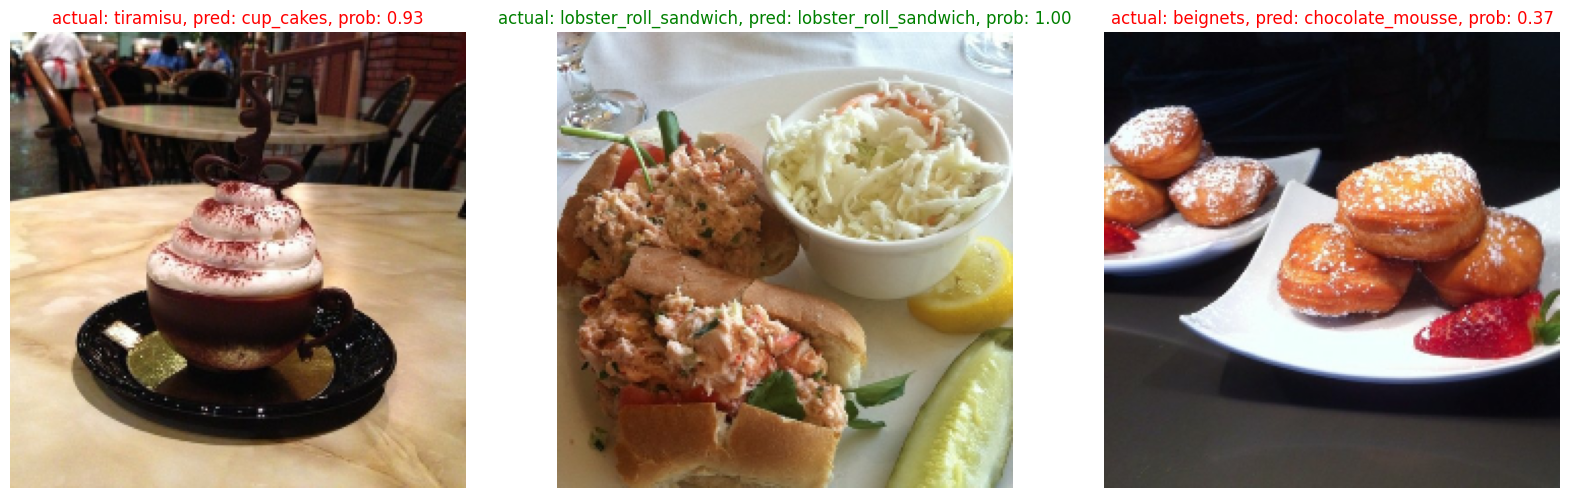

In [115]:
# make predictions on series of random images
import os
import random

plt.figure(figsize=(20, 10))
for i in range(3):
  # choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+'/'+class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # plot the image(s)
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Finding the Most Wrong Predictions

To gain deeper insights into our model's performance, it's beneficial to examine instances where the model confidently predicts an incorrect label (e.g., prediction probability of 0.95 or higher).

Let's outline the steps to accomplish this:

1. Retrieve all image file paths in the test dataset using the [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method.
2. Create a pandas DataFrame containing:
   - Image file paths
   - Ground truth labels
   - Predicted classes
   - Maximum prediction probabilities
   - Ground truth class names
   - Predicted class names
   *Note: While not strictly necessary, organizing data into a DataFrame facilitates visualization and analysis.*
3. Utilize the DataFrame to identify all incorrect predictions (where the ground truth label does not match the predicted class).
4. Sort the DataFrame based on incorrect predictions and highest maximum prediction probabilities.
5. Visualize the images with the highest prediction probabilities but incorrect predictions.


In [116]:
#1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [117]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({'img_path':filepaths,
                        'y_true':y_labels,
                        'y_pred':pred_classes,
                        'pred_conf': pred_probs.max(axis=1),
                        'y_true_classname':[class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  
0   0.847418        apple_pie                 gyoza  
1   0.964017        apple_pie             apple_pie  
2   0.959259        apple_pie             apple_pie  
3   0.658607        apple_pie  pulled_pork_sandwich  
4   0.367901        apple_pie             prime_rib

In [118]:
# 3. is the prediction correct?
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [119]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head()

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   

       pred_conf       y_true_classname y_pred_classname  pred_correct  
21810   0.999997               scallops        cup_cakes         False  
231     0.999995              apple_pie          waffles         False  
15359   0.999988  lobster_roll_sandwich        hamburger         False  
23539   0.999987   strawberry_shortcake  red_velvet_cake         False  
21400   0.999981                 samosa     spring_rolls         False

Just by comparing the ground truth classname (`y_true_classname`) and the prediction classname column (`y_pred_classname`), do you notice any trends?

It might be easier if we visualize them.

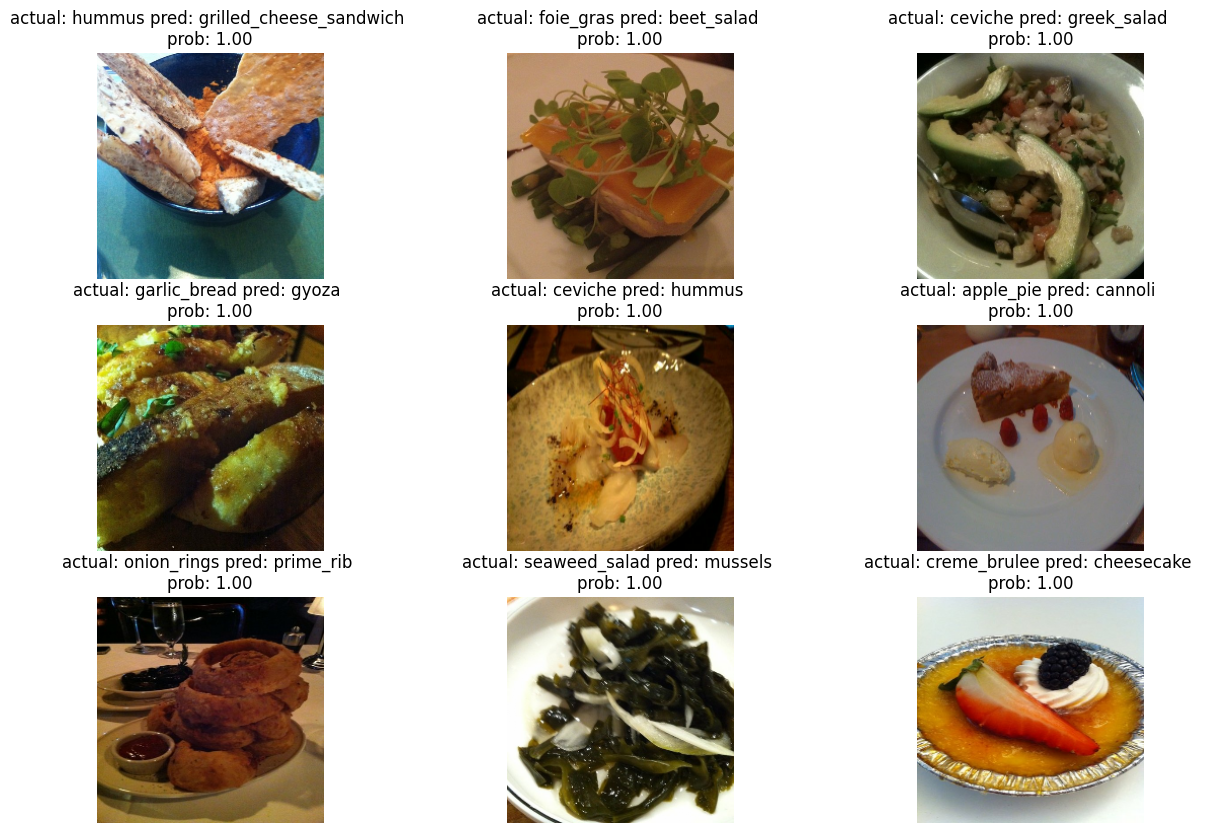

In [120]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 66
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): # it's like [10:19]
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale=True)
  _,_,_,_, pred_prob, y_true, y_pred, _ = row
  plt.imshow(img)
  plt.title(f"actual: {y_true} pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False);

## Test out the big dog model on test images as well as custom images of food

So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of food.

For this you might want to upload your own images to Google Colab or by putting them in a folder you can load into the notebook.

In [121]:
custom_food_images = []
for i in os.listdir("/content/101_food_classes_10_percent/custom_food_images/"):
  if i == ".ipynb_checkpoints":
    continue
  else:
    custom_food_images.append("/content/101_food_classes_10_percent/custom_food_images/"+i)
custom_food_images

['/content/101_food_classes_10_percent/custom_food_images/steak1.jpg',
 '/content/101_food_classes_10_percent/custom_food_images/chicken curry2.jpg',
 '/content/101_food_classes_10_percent/custom_food_images/pasta.jpg',
 '/content/101_food_classes_10_percent/custom_food_images/clam chowder.jpeg',
 '/content/101_food_classes_10_percent/custom_food_images/chicken wings.jpg',
 '/content/101_food_classes_10_percent/custom_food_images/gyros.jpg']

1/1 [==============================] - 0s 41ms/step


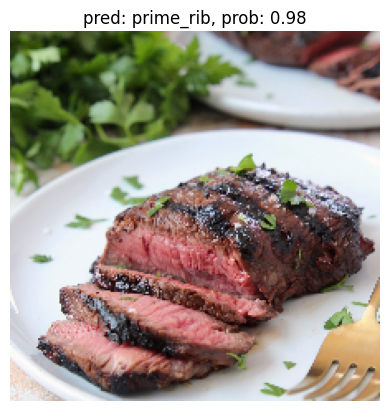

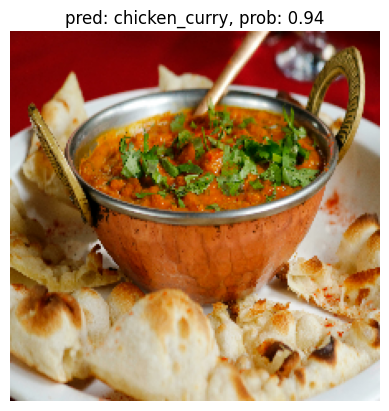

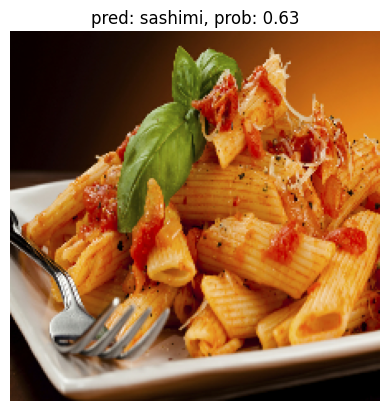

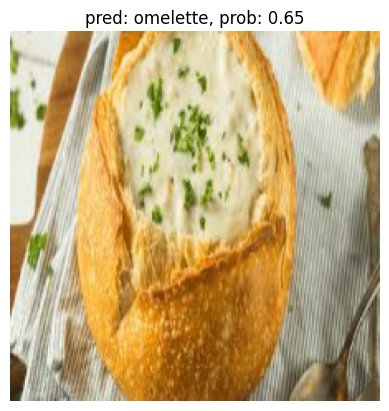

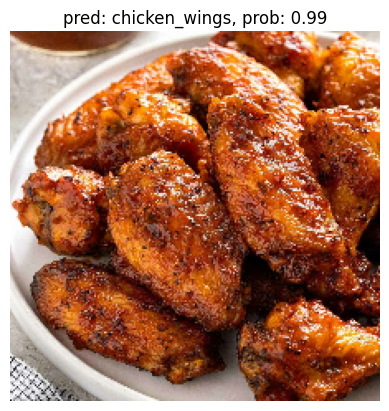

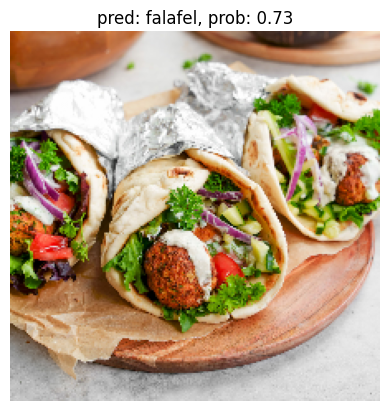

In [122]:
# make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);